In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pylab as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

from tensorflow.keras.utils import Sequence

In [2]:
def eom(u, t, gamma):
    alpha=-1
    beta=1
    delta=0.3
    gamma=gamma
    omega=1.2
    x, dx = u[0], u[1]
    ddx= gamma * np.cos(omega * t) - (delta * dx + alpha*x + beta * x**3)
    return [dx,ddx]


def duff_gen(X, delta_t):
    gamma_range = X[:,3]
    y = np.empty((len(gamma_range), 2))
    for j, gamma in enumerate(gamma_range):
        t_range = np.linspace(X[j,2], X[j,2]+delta_t, 1000, endpoint=False)
        func = lambda u,t: eom(u, t, gamma)
        gamma_data = odeint(func, [X[j,0],X[j,1]], t_range)
        y[j,:] = gamma_data[-1,:]
            
    return y

In [30]:
gamma_range = np.linspace(0,1,20, endpoint=False)
t_final = 50
delta_t = 0.5
num_steps = int(t_final / delta_t)

X0 = np.empty((len(gamma_range), 4))


for i, gamma in enumerate(gamma_range):
     X0[i,:] = [1,0,0,gamma]


y0 = duff_gen(X0,delta_t)

In [31]:
"""
So we want a network that takes (xt,vt) at some time t and predicts for (xt+deltat, vt+deltat) for fixed deltat.
Then we want to use (xt+deltat, vt+deltat) as the x0 for the next batch. 
"""          
# set up and train the network
input_shape = (np.shape(X0)[1], 1)
#opt = RMSprop()
opt = Adam(learning_rate=0.001)

model = Sequential()
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#model.add(layers.Flatten(input_shape=input_shape))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
#model.add(layers.Dense(32, activation='relu'))
#model.add(layers.Dense(32, activation='relu'))
#model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(32, activation='sigmoid'))
model.add(layers.Dense(32, activation='tanh'))
model.add(layers.Dense(2))
model.compile(optimizer=opt, loss='mse')
    

In [32]:
"""
Network generates its own training data (X values) from the last predicted values. This lets it propagate for an unknown
"""
t = 0
X = X0
y = y0
X_test = np.array([[1,0,0,0.37],[1,0,0,0.69]])
y_data = y
X_data = X
X_test_data = X_test
gamma_range = gamma_range.reshape(-1,1)
initial_range= gamma_range

for step in range(num_steps):
    print(step)
    history=model.fit(X_data, y_data, steps_per_epoch=10, epochs=step, validation_split=0.2, verbose=0)
    t = t+delta_t
    y = duff_gen(X, delta_t)
    y_data = np.vstack((y_data,y))
    X = np.hstack((model.predict(X),t*np.ones_like(X[:,1]).reshape((-1,1)),gamma_range))
    X_data = np.vstack((X_data,X))
    X_test = np.hstack((model.predict(X_test), 
                        t*np.ones_like(X_test[:,1]).reshape((-1,1)),
                        0.37*np.ones_like(X_test[:,1]).reshape((-1,1))))
    X_test_data =  np.vstack((X_test_data, X_test))
    
    
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


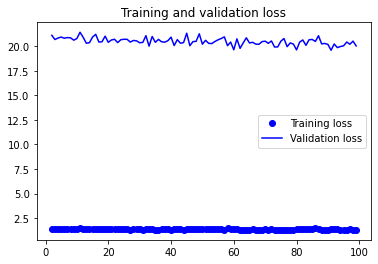

In [33]:
# evaluate the fitting validation and training losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs[1:], loss[1:], 'bo', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [34]:
X_test

array([[-1.60033011,  0.23121645, 50.        ,  0.37      ],
       [-1.60033011,  0.23121645, 50.        ,  0.37      ]])

Text(0, 0.5, 'v')

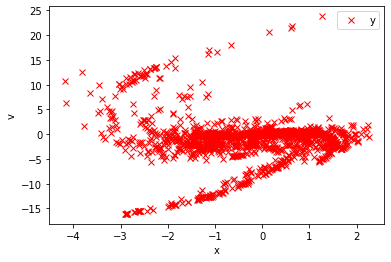

In [35]:
#make predictions on the dataset.

fig, ax = plt.subplots()
#ax.plot(X_test_data[:,0], X_test_data[:,1], 'rx', label="y_pred")
ax.plot(y_data[:,0], y_data[:,1], 'rx', label="y")
plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('v')

In [ ]:
from interpret.ext.blackbox import MimicExplainer

# "features" and "classes" fields are optional
# augment_data is optional and if true, oversamples the initialization examples to improve surrogate model accuracy to fit original model.  Useful for high-dimensional data where the number of rows is less than the number of columns. 
# max_num_of_augmentations is optional and defines max number of times we can increase the input data size.
# LGBMExplainableModel can be replaced with LinearExplainableModel, SGDExplainableModel, or DecisionTreeExplainableModel
explainer = MimicExplainer(model, 
                           x_train, 
                           LGBMExplainableModel, 
                           augment_data=True, 
                           max_num_of_augmentations=10, 
                           features=breast_cancer_data.feature_names, 
                           classes=classes)

In [ ]:
# you can use the training data or the test data here
global_explanation = explainer.explain_global(x_train)

# if you used the PFIExplainer in the previous step, use the next line of code instead
# global_explanation = explainer.explain_global(x_train, true_labels=y_test)

# sorted feature importance values and feature names
sorted_global_importance_values = global_explanation.get_ranked_global_values()
sorted_global_importance_names = global_explanation.get_ranked_global_names()


# alternatively, you can print out a dictionary that holds the top K feature names and values
global_explanation.get_feature_importance_dict()

In [ ]:
# explain the first data point in the test set
local_explanation = explainer.explain_local(x_test[0])

# sorted feature importance values and feature names
sorted_local_importance_names = local_explanation.get_ranked_local_names()
sorted_local_importance_values = local_explanation.get_ranked_local_values()